## Import Module

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

2025-08-24 01:00:13.289092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755997213.310516      85 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755997213.317097      85 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the Dataset

In [2]:
IMAGE_FOLDER = 'tusimple_processed/images'
MASK_FOLDER = 'tusimple_processed/masks'

In [3]:
def create_directories_if_not_exist(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("Directory Created: ", dir_path)
    else:
        print("Directory already exists: ", dir_path)

In [4]:
create_directories_if_not_exist(IMAGE_FOLDER)
create_directories_if_not_exist(MASK_FOLDER)

Directory Created:  tusimple_processed/images
Directory Created:  tusimple_processed/masks


### Copy Images to the Image Directory

In [5]:
CLIPS_PATH = "/kaggle/input/tusimple/TUSimple/train_set/clips"

# Iterate through the each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip: ", clip_dir)
    # Iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, '20.jpg')
    
        # Check if file is present
        if not os.path.isfile(frame_path):
            continue
    
        # Create new filename based on last 2 directory names
        temp = frame_path[:-7].split("/")[-2:]
        new_filename = f"{temp[0]}_{temp[1]}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)
    
        # copy the file 
        shutil.copy(frame_path, new_file_path)
    

Processing Clip:  0531
Processing Clip:  0601
Processing Clip:  0313-2
Processing Clip:  0313-1


In [6]:
print("Total Images in Dataset:", len(os.listdir(IMAGE_FOLDER)))

Total Images in Dataset: 3626


### Create Masks for the images

In [7]:
# Load the dataset json files
df1 = pd.read_json("/kaggle/input/tusimple/TUSimple/train_set/label_data_0313.json", lines=True)
df2 = pd.read_json("/kaggle/input/tusimple/TUSimple/train_set/label_data_0531.json", lines=True)
df3 = pd.read_json("/kaggle/input/tusimple/TUSimple/train_set/label_data_0601.json", lines=True)

# combine into single dataframe
df = pd.concat([df1, df2, df3])
df.head()

lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

In [8]:
# Create function for generating masks
def generate_lane_mask(row):
    # craete a mask of all zeros
    mask = np.zeros((720, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # Create mask; lane=1; non-lane=0;
    for lane in lanes:
        # exlude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # Create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed=False, color=(255, 255, 255), thickness=15)

    # generate mask filename
    temp = raw_file[:-7].split('/')[-2:]
    mask_filename = f"{temp[0]}_{temp[1]}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [9]:
# generate masks
for index, row in tqdm(df.iterrows(), total=len(df)):
    generate_lane_mask(row)
    

  0%|          | 0/3626 [00:00<?, ?it/s]

In [10]:
print("Total Masks in Dataset:", len(os.listdir(MASK_FOLDER)))

Total Masks in Dataset: 3626


### Data Visualization

In [11]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)

    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)

    # plot the image
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # show the images
    plt.show()
    
    

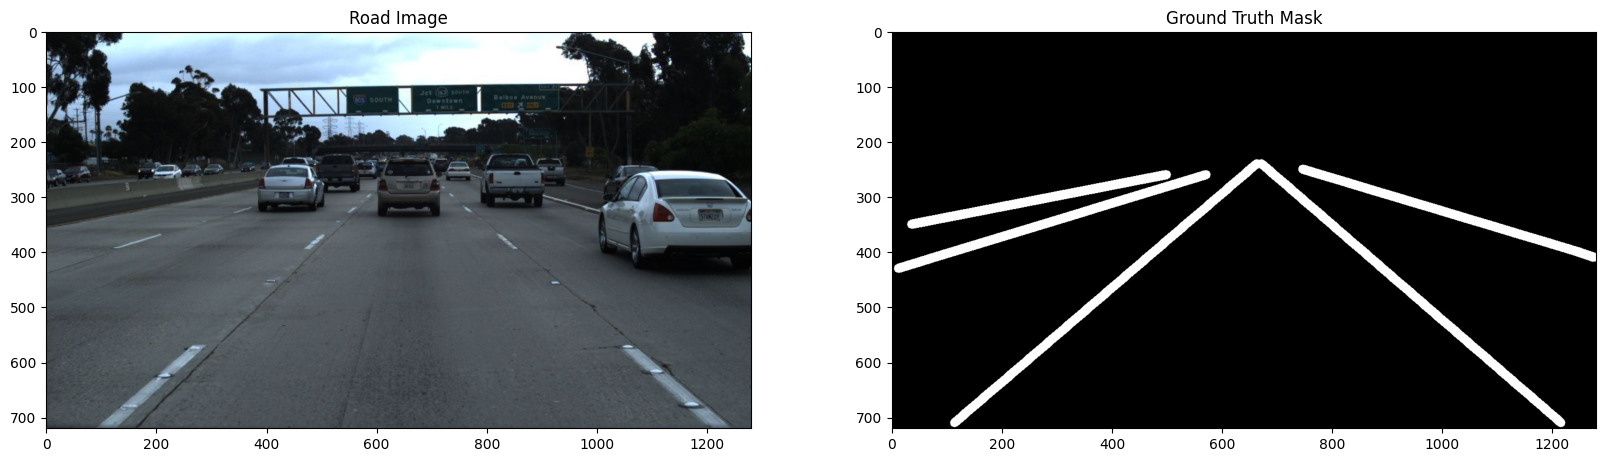

In [12]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

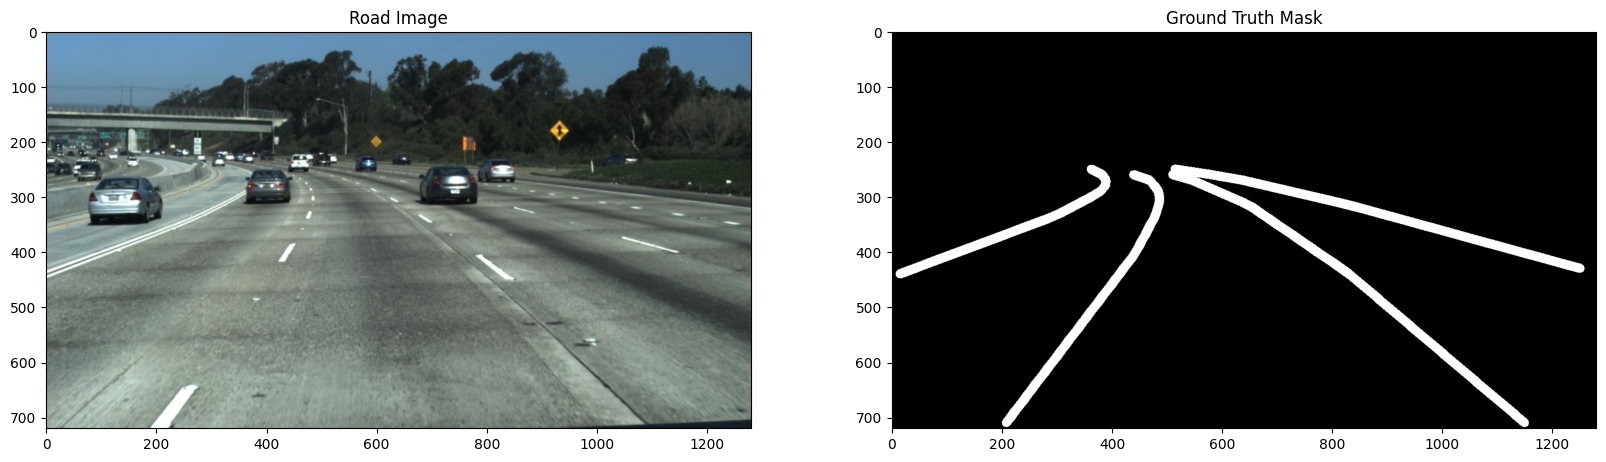

In [13]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

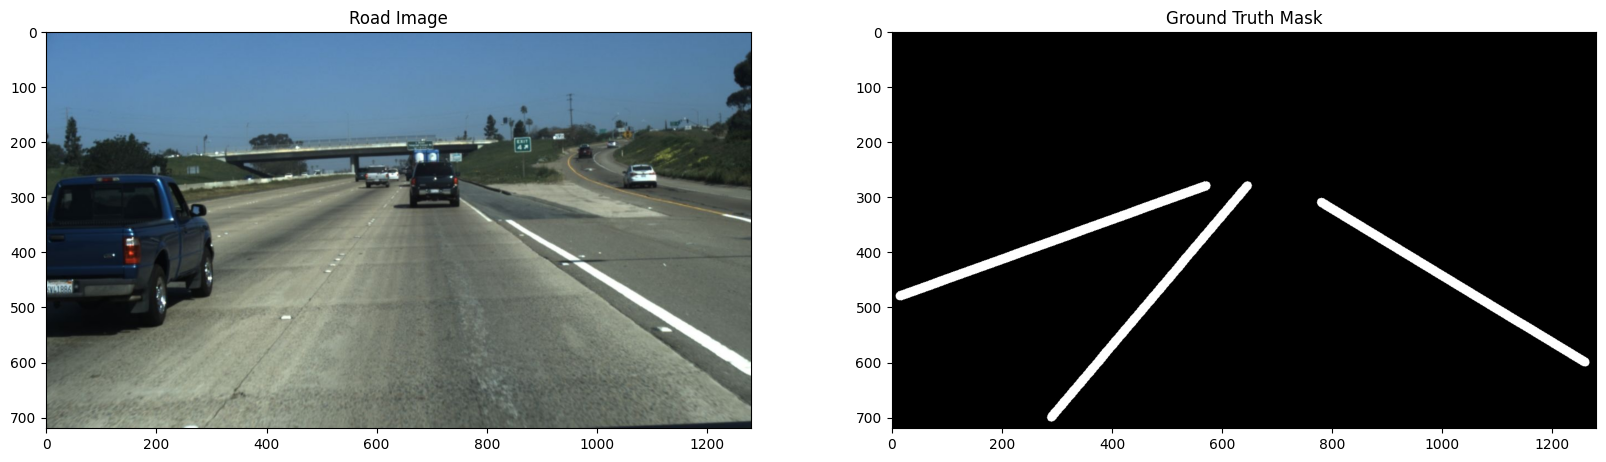

In [14]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

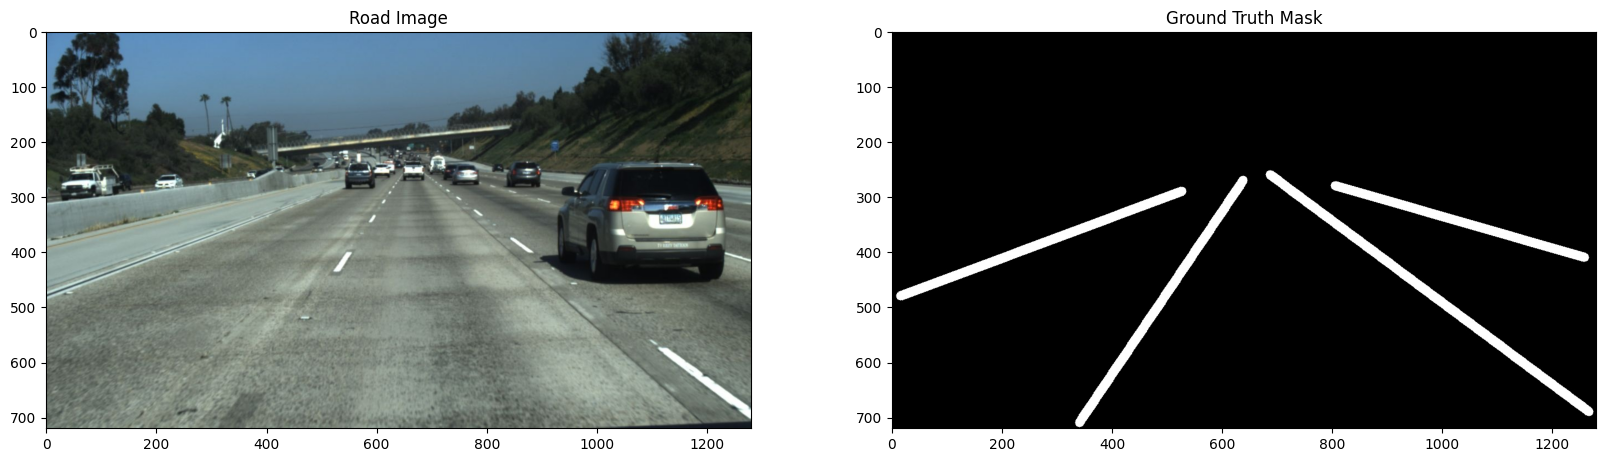

In [15]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

## Process Data for Training and Testing

In [16]:
train_image_folder = 'tusimple_processed/train/images'
test_image_folder = 'tusimple_processed/test/images'
train_mask_folder = 'tusimple_processed/train/masks'
test_mask_folder = 'tusimple_processed/test/masks'

In [17]:
for folder_path in [train_image_folder, test_image_folder, train_mask_folder, test_mask_folder]:
    create_directories_if_not_exist(folder_path)    

Directory Created:  tusimple_processed/train/images
Directory Created:  tusimple_processed/test/images
Directory Created:  tusimple_processed/train/masks
Directory Created:  tusimple_processed/test/masks


In [18]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith('.jpg')]

# Split for train and test
train_images, test_images = train_test_split(images, test_size = 0.1, random_state = 42)
train_masks, test_masks = train_test_split(masks, test_size = 0.1, random_state = 42)

In [19]:
len(train_images), len(test_images)

(3263, 363)

In [20]:
# move files to the corresponding folders
for file in train_images:
    
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(train_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(train_mask_folder, file)
    shutil.move(source, destination)

for file in test_images:
    
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(test_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(test_mask_folder, file)
    shutil.move(source, destination)

### Feature Engineering

In [21]:
def load_image(image_path, mask_path):
    size = [224, 224]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image/255.0 # normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size)
    mask = mask/255.0 # normalize to [0, 1]

    return image, mask

def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.jpg')])
    mask_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith('.jpg')])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))

    return dataset
    

In [22]:
# load dataset from folder
train_dataset = dataset_from_folder(train_image_folder, train_mask_folder)
test_dataset = dataset_from_folder(test_image_folder, test_mask_folder)

I0000 00:00:1755997256.468025      85 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [23]:
# set config
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# optimize for performance improvement
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



In [24]:
def display_sample(image_list):
    plt.figure(figsize=(10, 10))

    title = ['Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

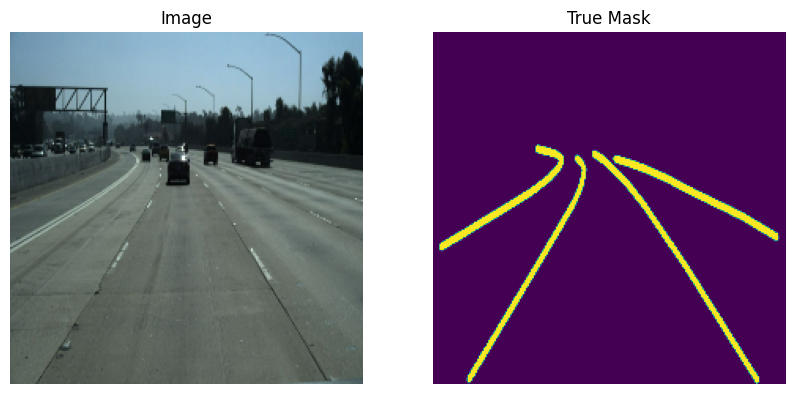

In [25]:
for image, mask in train_dataset.take(1):
    display_sample([image[0], mask[0]])

## Model Creating - VGG UNet

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, Concatenate, UpSampling2D
from tensorflow.keras.models import Model

def VGG16_UNet(input_shape=(None, None, 3)):
    def Conv2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        x = Conv2D(n_filters, (1, 1), strides=1, padding='same', kernel_initializer='glorot_normal', activation='elu')(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding='same', kernel_initializer='glorot_normal', activation='elu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True) # training + test-time dropout
        return x

    # VGG16 encoder
    vgg16 = VGG16(weights='imagenet', include_top = False, input_shape=input_shape)

    # Unfreeze VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = True

    # Encoder layers
    inputs = vgg16.input
    layer1 = vgg16.get_layer('block1_conv2').output
    layer2 = vgg16.get_layer('block2_conv2').output
    layer3 = vgg16.get_layer('block3_conv3').output
    layer4 = vgg16.get_layer('block4_conv3').output
    layer5 = vgg16.get_layer('block5_conv3').output

    # Decoder layers
    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(512, (3, 3), (1, 1), merge6)

    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(256, (3, 3), (1, 1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(128, (3, 3), (1, 1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(64, (3, 3), (1, 1), merge9)

    output = Conv2D(1, (1, 1), strides=(1, 1), activation='sigmoid', name='output')(layer9)

    return Model(inputs=inputs, outputs=output)

model = VGG16_UNet(input_shape=(224, 224, 3)) # Adjust input shape as needed
    

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
import tensorflow
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred):
    y_true_f=K.flatten(y_true)
    mu = y_pred[:,:,:,0]
    y_pred_f =K.flatten(mu)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))

def precision_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_pred_f) + K.epsilon()))

def accuracy(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)

    # True positives
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))

    # True negatives
    true_negatives = K.sum(K.round(K.clip((1 - y_true_f) * (1 - y_pred_f), 0, 1)))

    # Total pixels
    total_pixels = K.cast(tensorflow.size(y_true_f), K.floatx())

    # Accuracy
    accuracy_value = (true_positives * true_negatives) / total_pixels
    
    return accuracy_value
    

In [36]:
# compile the model
model.compile(optimizer='adam', loss=dice_loss, metrics = [dice_coefficient, precision_smooth, recall_smooth, accuracy])
print('Number of parameters: ', model.count_params())

Number of parameters:  18636289


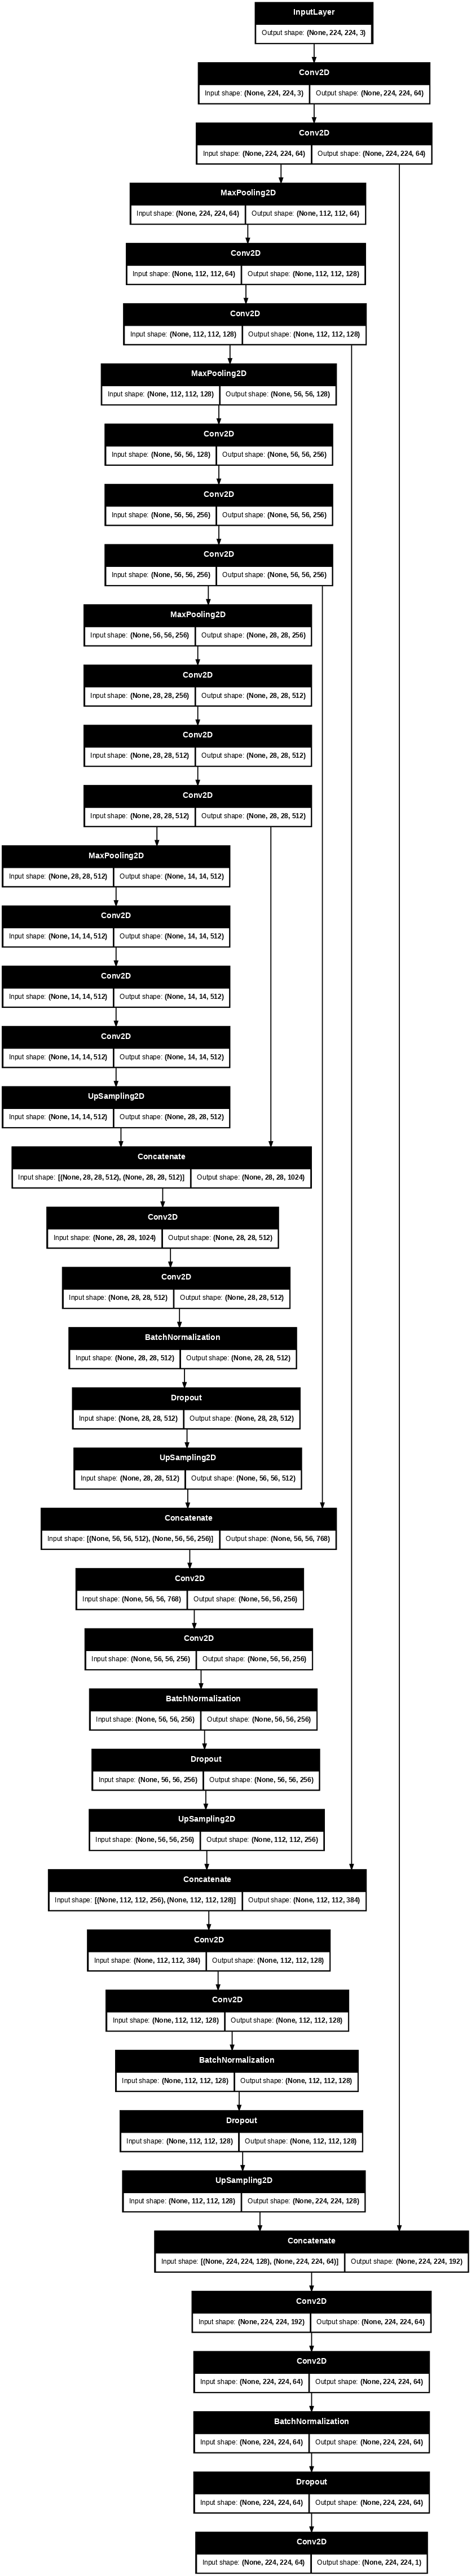

In [37]:
# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=64)

In [38]:
# create mask from prediction
def create_mask(pred_mask):
    # round to closest
    pred_mask = tf.math.round(pred_mask)
    return pred_mask

def show_predictions(dataset=None, num=1):
    if dataset:
        for images, masks in dataset.take(num):
            pred_mask = model.predict(images)
            pred_mask = create_mask(pred_mask[0])
            display_sample([images[0], masks[0], pred_mask])

        

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


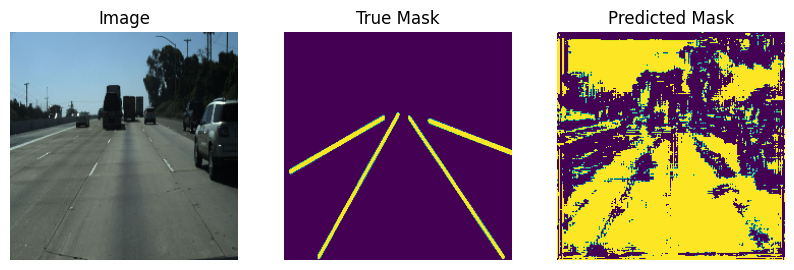

In [39]:
show_predictions(train_dataset, 1)

In [40]:
# callbacks and logs
from tensorflow.keras import callbacks
import datetime

class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(test_dataset, 1)
        print(f'Sample prediction after epoch {epoch}')
logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq=-1),
    callbacks.EarlyStopping(patience=5, verbose=1),
    callbacks.ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)
]


In [41]:
EPOCHS=10
steps_per_epoch=len(os.listdir(train_image_folder))// BATCH_SIZE
validation_steps = len(os.listdir(test_image_folder))// BATCH_SIZE

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/stepstep - accuracy: 41941.1289 - dice_coefficient: 0.3089 - loss: 0.6911 - precision_smooth: 0.2040 - recall_smooth: 0.76


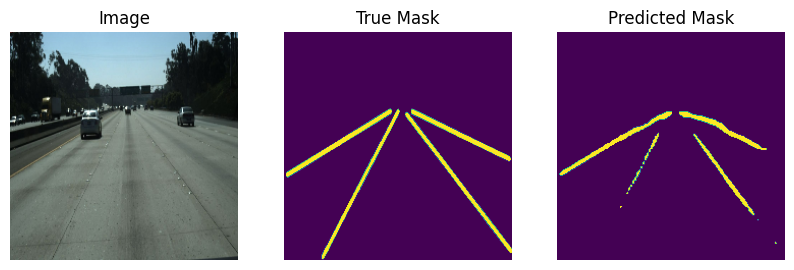

Sample prediction after epoch 0

Epoch 1: val_loss improved from inf to 0.41775, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 92s 532ms/step - accuracy: 41988.1992 - dice_coefficient: 0.3102 - loss: 0.6898 - precision_smooth: 0.2052 - recall_smooth: 0.7694 - val_accuracy: 30147.7676 - val_dice_coefficient: 0.5822 - val_loss: 0.4178 - val_precision_smooth: 0.7909 - val_recall_smooth: 0.4610
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/stepstep - accuracy: 48841.6484 - dice_coefficient: 0.6596 - loss: 0.3404 - precision_smooth: 0.5857 - recall_smooth: 0.75


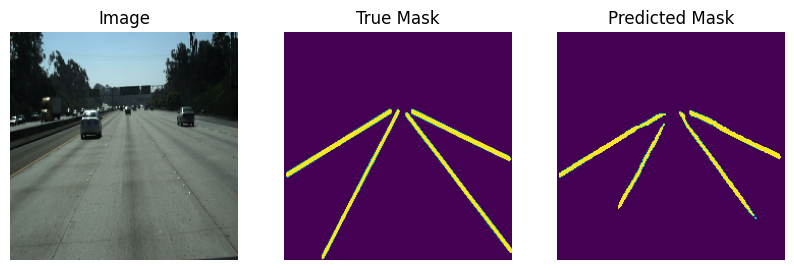

Sample prediction after epoch 1

Epoch 2: val_loss improved from 0.41775 to 0.30622, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 507ms/step - accuracy: 48842.4570 - dice_coefficient: 0.6599 - loss: 0.3401 - precision_smooth: 0.5861 - recall_smooth: 0.7577 - val_accuracy: 40415.3633 - val_dice_coefficient: 0.6938 - val_loss: 0.3062 - val_precision_smooth: 0.7897 - val_recall_smooth: 0.6195
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/stepstep - accuracy: 50550.8438 - dice_coefficient: 0.7301 - loss: 0.2699 - precision_smooth: 0.6868 - recall_smooth: 0.77


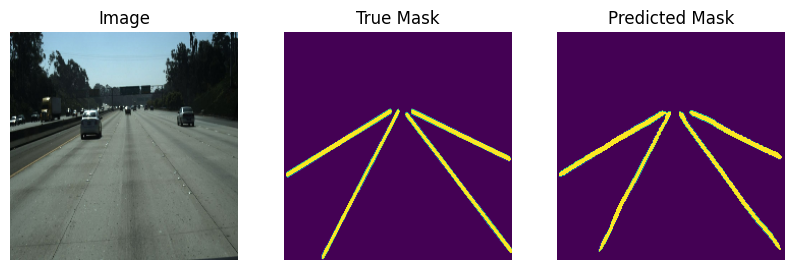

Sample prediction after epoch 2

Epoch 3: val_loss improved from 0.30622 to 0.25372, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 504ms/step - accuracy: 50550.1797 - dice_coefficient: 0.7301 - loss: 0.2699 - precision_smooth: 0.6870 - recall_smooth: 0.7797 - val_accuracy: 48691.5156 - val_dice_coefficient: 0.7463 - val_loss: 0.2537 - val_precision_smooth: 0.7440 - val_recall_smooth: 0.7492
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/stepstep - accuracy: 50952.5391 - dice_coefficient: 0.7448 - loss: 0.2552 - precision_smooth: 0.7095 - recall_smooth: 0.78


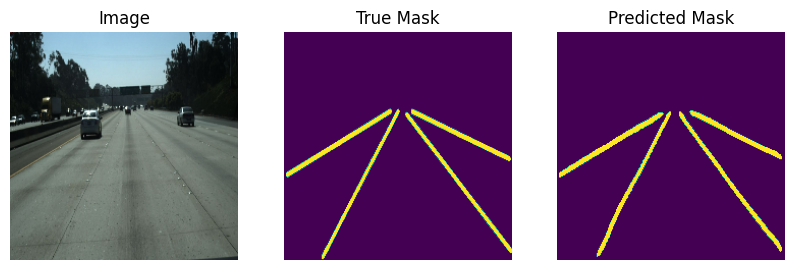

Sample prediction after epoch 3

Epoch 4: val_loss improved from 0.25372 to 0.23682, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 505ms/step - accuracy: 50952.7188 - dice_coefficient: 0.7449 - loss: 0.2551 - precision_smooth: 0.7096 - recall_smooth: 0.7844 - val_accuracy: 50218.9883 - val_dice_coefficient: 0.7632 - val_loss: 0.2368 - val_precision_smooth: 0.7549 - val_recall_smooth: 0.7721
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/stepstep - accuracy: 51927.4961 - dice_coefficient: 0.7604 - loss: 0.2396 - precision_smooth: 0.7274 - recall_smooth: 0.79


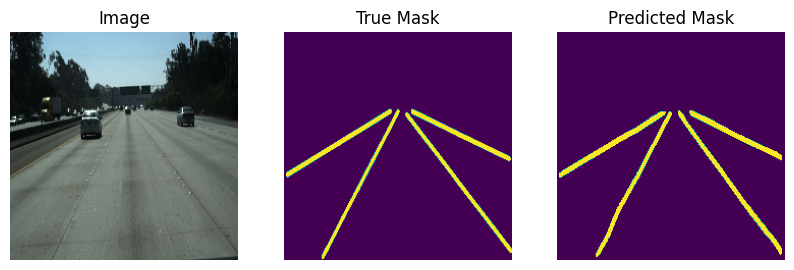

Sample prediction after epoch 4

Epoch 5: val_loss did not improve from 0.23682
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 494ms/step - accuracy: 51923.8711 - dice_coefficient: 0.7604 - loss: 0.2396 - precision_smooth: 0.7274 - recall_smooth: 0.7970 - val_accuracy: 52286.5156 - val_dice_coefficient: 0.7620 - val_loss: 0.2380 - val_precision_smooth: 0.7231 - val_recall_smooth: 0.8058
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/stepstep - accuracy: 52496.6211 - dice_coefficient: 0.7715 - loss: 0.2285 - precision_smooth: 0.7390 - recall_smooth: 0.80


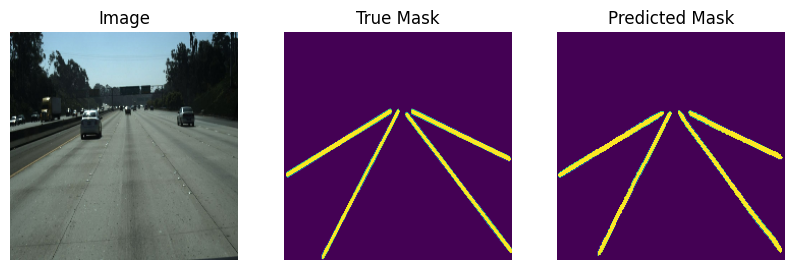

Sample prediction after epoch 5

Epoch 6: val_loss improved from 0.23682 to 0.23139, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 504ms/step - accuracy: 52493.1523 - dice_coefficient: 0.7715 - loss: 0.2285 - precision_smooth: 0.7390 - recall_smooth: 0.8070 - val_accuracy: 52073.5898 - val_dice_coefficient: 0.7686 - val_loss: 0.2314 - val_precision_smooth: 0.7388 - val_recall_smooth: 0.8014
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/stepstep - accuracy: 52861.9258 - dice_coefficient: 0.7759 - loss: 0.2241 - precision_smooth: 0.7458 - recall_smooth: 0.80


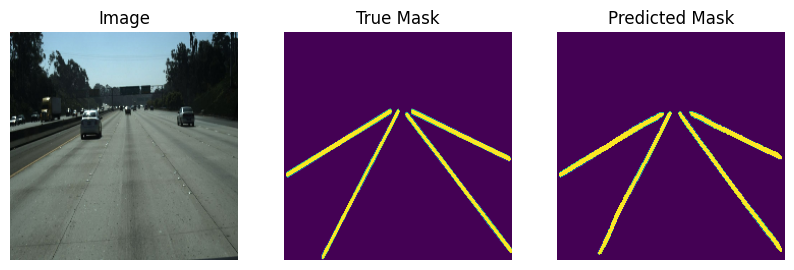

Sample prediction after epoch 6

Epoch 7: val_loss improved from 0.23139 to 0.22657, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 52858.6289 - dice_coefficient: 0.7759 - loss: 0.2241 - precision_smooth: 0.7458 - recall_smooth: 0.8089 - val_accuracy: 52720.8398 - val_dice_coefficient: 0.7734 - val_loss: 0.2266 - val_precision_smooth: 0.7391 - val_recall_smooth: 0.8116
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/stepstep - accuracy: 52871.8555 - dice_coefficient: 0.7799 - loss: 0.2201 - precision_smooth: 0.7502 - recall_smooth: 0.81


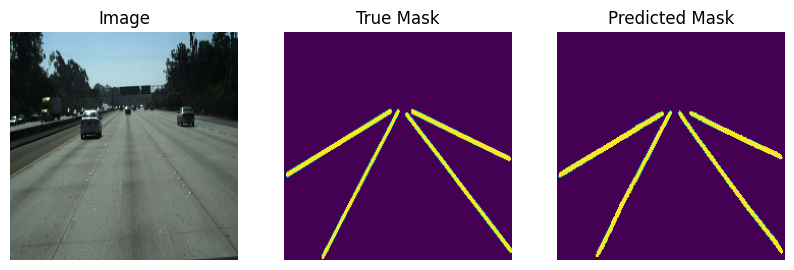

Sample prediction after epoch 7

Epoch 8: val_loss improved from 0.22657 to 0.22252, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 505ms/step - accuracy: 52870.7031 - dice_coefficient: 0.7799 - loss: 0.2201 - precision_smooth: 0.7503 - recall_smooth: 0.8122 - val_accuracy: 51638.0586 - val_dice_coefficient: 0.7775 - val_loss: 0.2225 - val_precision_smooth: 0.7623 - val_recall_smooth: 0.7937
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/stepstep - accuracy: 53288.9766 - dice_coefficient: 0.7850 - loss: 0.2150 - precision_smooth: 0.7556 - recall_smooth: 0.81


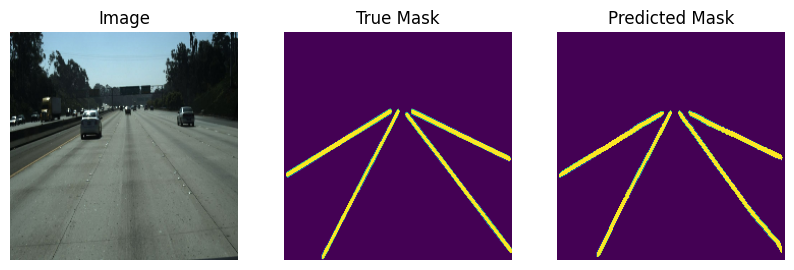

Sample prediction after epoch 8

Epoch 9: val_loss did not improve from 0.22252
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 495ms/step - accuracy: 53287.1914 - dice_coefficient: 0.7851 - loss: 0.2149 - precision_smooth: 0.7556 - recall_smooth: 0.8173 - val_accuracy: 52037.0039 - val_dice_coefficient: 0.7774 - val_loss: 0.2226 - val_precision_smooth: 0.7563 - val_recall_smooth: 0.7999
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/stepstep - accuracy: 53678.6406 - dice_coefficient: 0.7919 - loss: 0.2081 - precision_smooth: 0.7641 - recall_smooth: 0.82


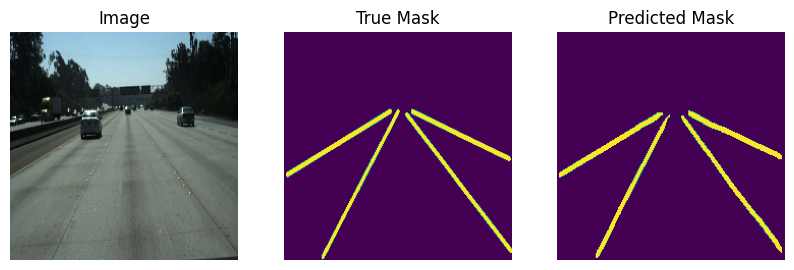

Sample prediction after epoch 9

Epoch 10: val_loss did not improve from 0.22252
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 495ms/step - accuracy: 53675.0430 - dice_coefficient: 0.7919 - loss: 0.2081 - precision_smooth: 0.7641 - recall_smooth: 0.8221 - val_accuracy: 51844.0156 - val_dice_coefficient: 0.7686 - val_loss: 0.2314 - val_precision_smooth: 0.7420 - val_recall_smooth: 0.7976


In [42]:
# train the model
history=model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
    
)

### Plot the Metrics

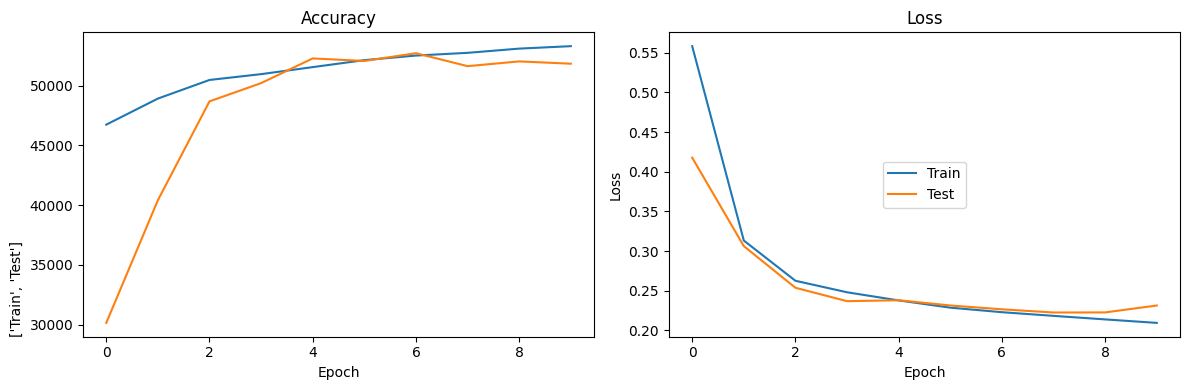

In [46]:
# plot train and val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel(['Train', 'Test'], loc='bottom')

# plot train and loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='center')

plt.tight_layout()
plt.show()

### Load the best model

In [49]:
best_model = tf.keras.models.load_model('best_model.keras', custom_objects={'dice_loss':dice_loss, 
                                                                            'dice_coefficient':dice_coefficient,
                                                                            'precision_smooth':precision_smooth,
                                                                            'recall_smooth':recall_smooth,
                                                                            'accuracy':accuracy
                                                                           })
# best_model.compile(optimizer='adam', loss=dice_loss, metrics = [dice_coefficient, precision_smooth, recall_smooth, accuracy])
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 55,905,029 (213.26 MB)

 Trainable params: 18,634,369 (71.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 37,268,740 (142.17 MB)

## Test Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


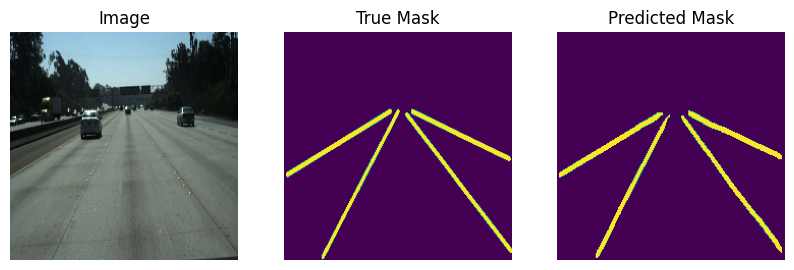

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


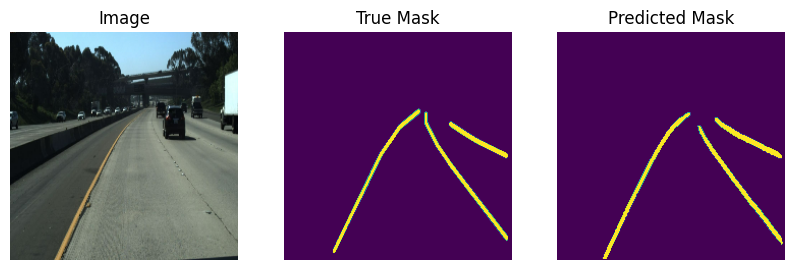

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


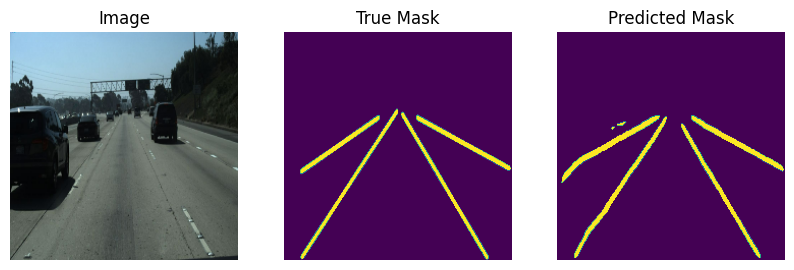

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


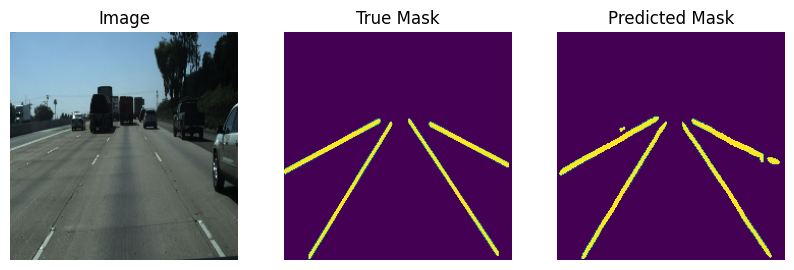

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


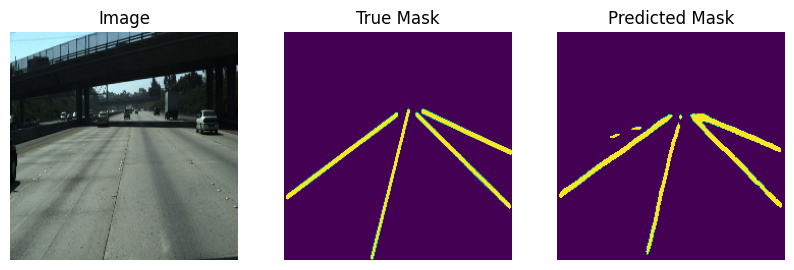

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


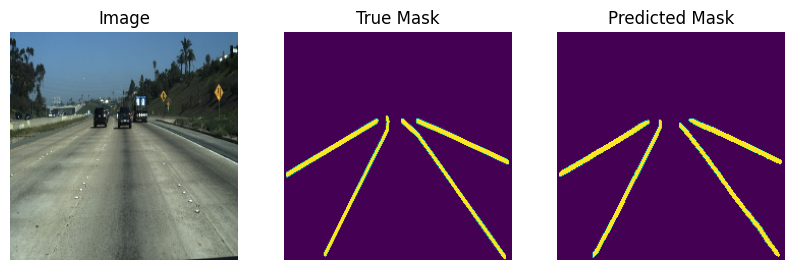

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


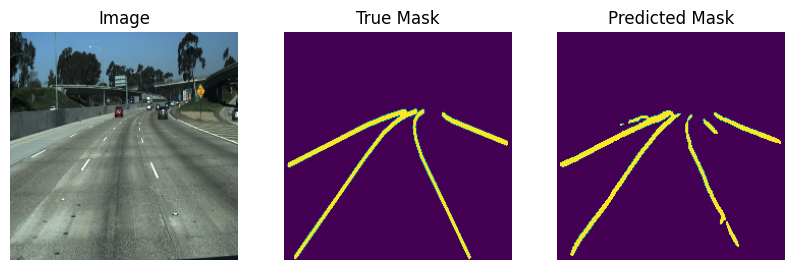

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


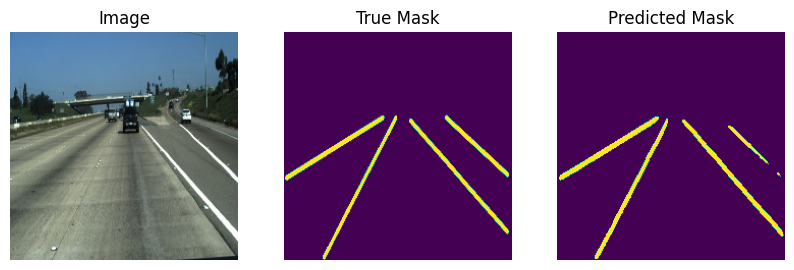

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


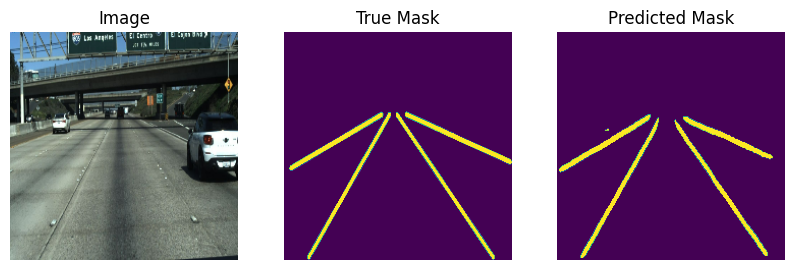

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


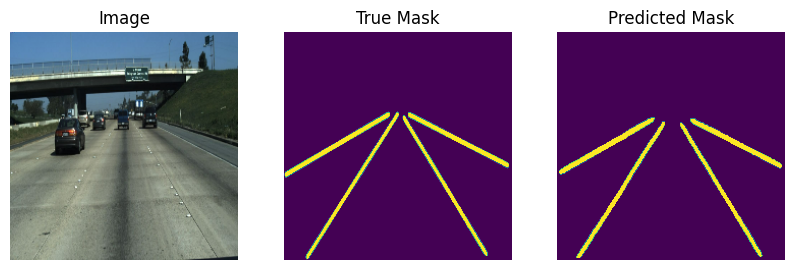

In [50]:
show_predictions(test_dataset, 10)

## Test from Image Path

In [51]:
def load_test_image(image_path):
    size = [224, 224]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image/255.0 # normalize to [0, 1]
    return image

def display_test_sample(image_list):
    plt.figure(figsize=(10, 10))

    title = ['Image', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


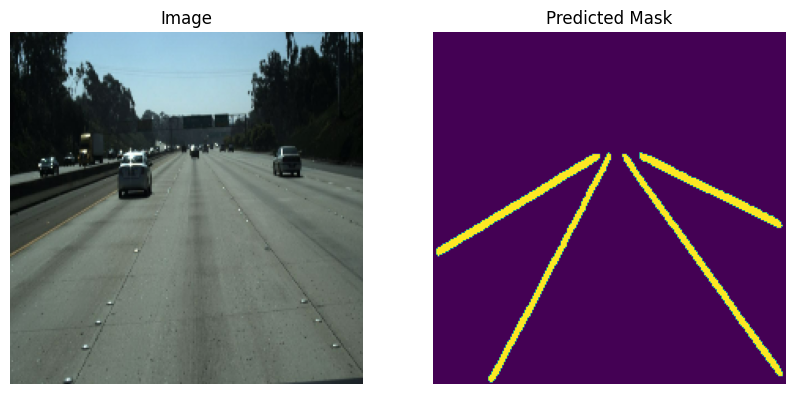

In [53]:
image_path = "/kaggle/input/tusimple/TUSimple/train_set/clips/0313-1/10000/20.jpg"
image = load_test_image(image_path)
test_image = tf.expand_dims(image, axis=0)
pred_mask = best_model.predict(test_image)
pred_mask = create_mask(pred_mask[0])
display_test_sample([image, pred_mask])